In [13]:
import torch
from torch.utils.data import DataLoader, Dataset

# Define a simple dataset class
class SimpleDataset(Dataset):
    def __init__(self):
        # Create two simple tensors
        self.data = [torch.tensor([0, 0, 0, 0, 0], dtype=torch.float32),     #cat
                     torch.tensor([1, 1, 1, 1, 1], dtype=torch.float32),     #bird
                     torch.tensor([2, 2, 2, 2, 2], dtype=torch.float32),     #cow
                     torch.tensor([3, 3, 3, 3, 3], dtype=torch.float32)]     #dog

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        original_tensor = self.data[idx]
        
        # Augmentations: add 1 and add 2
        aug1 = original_tensor + 1
        aug2 = original_tensor + 2
        
        return aug1, aug2

# Create the dataset
dataset = SimpleDataset()

# Create DataLoader
batch_size = 2
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader and print results
for i, (aug1, aug2) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Augmentation 1:\n{aug1}")
    print(f"  Augmentation 2:\n{aug2}")
    # Stop after the first batch


Batch 0:
  Augmentation 1:
tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.]])
  Augmentation 2:
tensor([[2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])
Batch 1:
  Augmentation 1:
tensor([[3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.]])
  Augmentation 2:
tensor([[4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5.]])


In [15]:
for aug1, aug2 in train_loader:
    augs = torch.cat((aug1, aug2), dim=0)
augs
#c1
#d1
#c2
#d2
# we need to use btachsize shift loss version +compli calc for augs > 2 too

tensor([[3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5.]])

Another way is to make the conc such a way that it will be c1c1c3 d1d2d3. you can try to do it in the .cat dim=0 cahnges or do this at Imgadedataset class.

With this way ti calculate positive indices is easier than the above for augs>2

In [17]:
import torch
from torch.utils.data import DataLoader, Dataset

# Define a simple dataset class
class SimpleDataset(Dataset):
    def __init__(self):
        # Create two simple tensors
        self.data = [torch.tensor([0, 0, 0, 0, 0], dtype=torch.float32),     #cat
                     torch.tensor([1, 1, 1, 1, 1], dtype=torch.float32),     #bird
                     torch.tensor([2, 2, 2, 2, 2], dtype=torch.float32),     #cow
                     torch.tensor([3, 3, 3, 3, 3], dtype=torch.float32)]     #dog

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        original_tensor = self.data[idx]
        
        # Augmentations: add 1 and add 2
        aug1 = original_tensor + 1
        aug2 = original_tensor + 2
        
        return aug1, aug2

# Create the dataset
dataset = SimpleDataset()

# Create DataLoader
batch_size = 2
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for aug1, aug2 in train_loader:
    # Stack along a new dimension and then reshape to interleave
    augs = torch.stack((aug1, aug2), dim=1).reshape(-1, aug1.shape[-1])

    #print(augs)
augs
#c1
#c2
#d1
#d2


tensor([[3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5.]])

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt

In [45]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Look for .jpg and .jpeg files
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.lower().endswith(('.jpg', '.jpeg'))]


    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        # Open image using PIL
        image = Image.open(img_path).convert('RGB')

        # Convert PIL image to numpy array
        image = np.array(image).astype(np.float32) / 255.0
        
        # Convert numpy array to torch tensor
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change from HWC to CHW format

        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "../animals"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 5

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    total_size = len(dataset)
    val_size = int(total_size * val_percentage)
    train_size = total_size - val_size
    
    # Ensure that we do not have empty splits
    if train_size <= 0:
        train_size = total_size
        val_size = 0
    
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

In [46]:
len(dataset)

10

In [47]:
for i, (image1, image2) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    


Batch 0:
  Image1: torch.Size([5, 3, 96, 96])
  Image2: torch.Size([5, 3, 96, 96])
Batch 1:
  Image1: torch.Size([5, 3, 96, 96])
  Image2: torch.Size([5, 3, 96, 96])


Shape of image1: torch.Size([5, 3, 96, 96])
Shape of image2: torch.Size([5, 3, 96, 96])
Batch size: 5


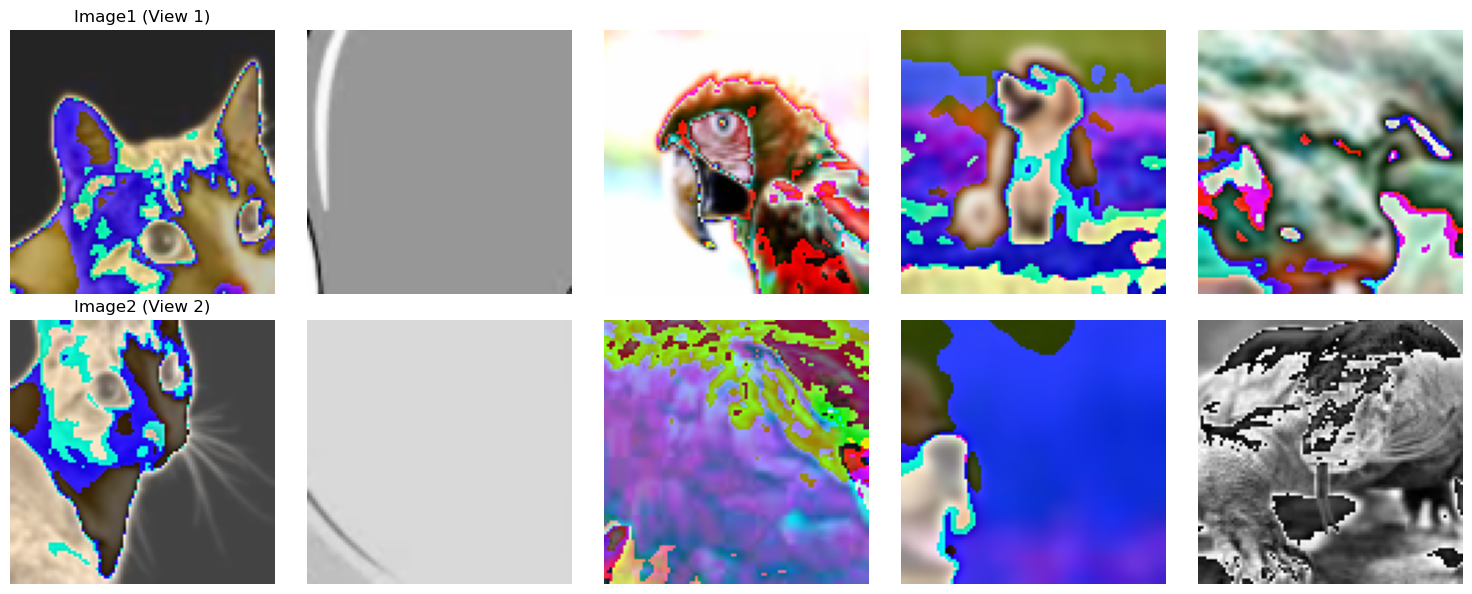

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert tensor to numpy image
def tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0).numpy()  # Convert from CHW to HWC
    image = (image * 255).astype(np.uint8)  # Scale to 0-255
    return image

# Fetch a batch from the DataLoader
for i, (image1, image2) in enumerate(train_loader):
    if i == 0:  # Get the first batch
        print("Shape of image1:", image1.shape)
        print("Shape of image2:", image2.shape)
        break

# Get the batch size (number of images in the batch)
batch_size = image1.shape[0]
print("Batch size:", batch_size)

# Create a grid to display all images
fig, axes = plt.subplots(2, batch_size, figsize=(15, 6))

# Plot each image from image1 and image2
for j in range(batch_size):
    axes[0, j].imshow(tensor_to_image(image1[j]))
    axes[0, j].axis('off')
    axes[1, j].imshow(tensor_to_image(image2[j]))
    axes[1, j].axis('off')

# Set titles for rows
axes[0, 0].set_title('Image1 (View 1)')
axes[1, 0].set_title('Image2 (View 2)')

plt.tight_layout()
plt.show()
